# Plot forces for flow past cylinder
## grid1 case
## Compare differences with Strelets factor

In [1]:
%%capture
import sys
sys.path.insert(1, '../utilities')
import litCdData
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Some needed functions for postprocessing

def concatforces(filelist):
    """
    Concatenate all the data in a list of files given by filelist, without overlaps in time
    """
    for ifile, file in enumerate(filelist):
        dat=np.loadtxt(file, skiprows=1)
        if ifile==0:
            alldat = dat
        else:
            lastt   = alldat[-1,0]    # Get the last time
            filt    = dat[:,0]>lastt
            gooddat = dat[filt,:]
            alldat  = np.vstack((alldat, gooddat))
    return alldat

# Calculate time average
def timeaverage(time, f, t1, t2):
    filt = ((time[:] >= t1) & (time[:] <= t2))
    # Filtered time
    t     = time[filt]
    # The total time
    dt = np.amax(t) - np.amin(t)
    #  Filtered field
    filtf = f[filt]
     # Compute the time average as an integral
    avg = np.trapz(filtf, x=t, axis=0) / dt
    return avg

def tukeyWindow(N, params={'alpha':0.1}):
    """
    The Tukey window
    see https://en.wikipedia.org/wiki/Window_function#Tukey_window
    """
    alpha = params['alpha']
    w = np.zeros(N)
    L = N+1
    for n in np.arange(0, int(N//2) + 1):
        if ((0 <= n) and (n < 0.5*alpha*L)):
            w[n] = 0.5*(1.0 - np.cos(2*np.pi*n/(alpha*L)))
        elif ((0.5*alpha*L <= n) and (n <= N/2)):
            w[n] = 1.0
        else:
            print("Something wrong happened at n = ",n)
        if (n != 0): w[N-n] = w[n]
    return w

# FFT's a signal, returns 1-sided frequency and spectra
def getFFT(t, y, normalize=False, window=True):
    """
    FFT's a signal, returns 1-sided frequency and spectra
    """
    n    = len(y)
    k    = np.arange(n)
    dt   = np.mean(np.diff(t))
    frq  = k/(n*dt)
    if window:    w = tukeyWindow(n)
    else:         w = 1.0
    if normalize: L = len(y)
    else:         L = 1.0
    FFTy = np.fft.fft(w*y)/L 
    
    # Take the one sided version of it
    freq = frq[range(int(n//2))]
    FFTy = FFTy[range(int(n//2))]
    return freq, FFTy

In [3]:
# Basic problem parameters
D     = 6            # Cylinder diameter
U     = 20           # Freestream velocity
Lspan = 24           # Spanwise length
A     = D*Lspan      # frontal area
rho   = 1.225        # density
Q     = 0.5*rho*U*U  # Dynamic head
vis   = 1.8375e-5    # viscosity
ReNum = rho*U*D/vis  # Reynolds number

#avgt = [160.0, 260.0] # Average times
saveinfo = False
alldata = []

In [4]:
            # Label,            Filenames                                        averaging times
runlist = [ ['sigmaMax=1',  ['../cylgrid1new_sst_iddes_01/forces01.dat', '../cylgrid1new_sst_iddes_01/forces02.dat', '../cylgrid1new_sst_iddes_01/forces03.dat'], 
             [400, 900], {'vis':1.8375e-5}],
           ['sigmaMax=0',  ['forces01.dat'],                                        [160, 800], {'vis':1.8375e-5}],
          ]

alldata = []
for run in runlist:
    forcedat = concatforces(run[1])
    t        = forcedat[:,0]*U/D  # Non-dimensional time
    alldata.append([run[0], t, forcedat, run[2], run[3]])

In [5]:
#print(alldata)
print('%30s   %10s %10s'%("Case", "avgCd", "avgCl"))
for run in alldata:
    label = run[0]
    t     = run[1]
    forcedat = run[2]
    avgt  = run[3]
    Cd = (forcedat[:,1]+forcedat[:,4])/(Q*A)
    Cl = (forcedat[:,2]+forcedat[:,5])/(Q*A)
    # Calculate averaged Cp, Cd
    avgCd = timeaverage(t, Cd, avgt[0], avgt[1])
    avgCl = timeaverage(t, Cl, avgt[0], avgt[1])
    print('%30s   %10f %10f'%(label, avgCd, avgCl))
    #print("Avg Cd = %f"%avgCd)
    #%print("Avg Cl = %f"%avgCl)

                          Case        avgCd      avgCl
                    sigmaMax=1     0.326385   0.016078
                    sigmaMax=0     0.787425   0.019762


## Plot Lift and Drag coefficients

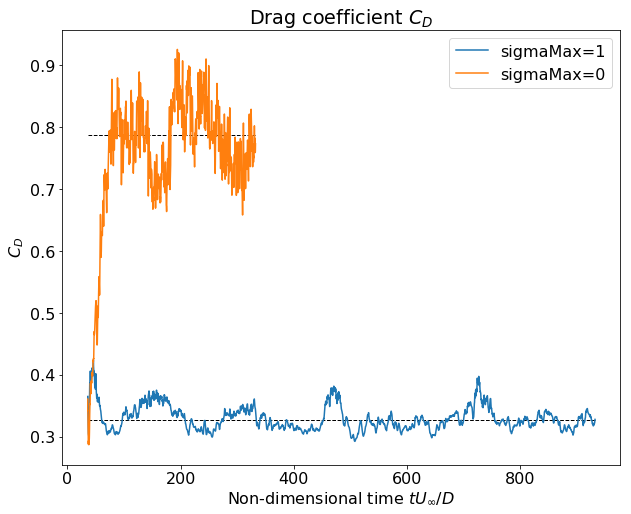

In [6]:
plt.rc('font', size=16)
plt.figure(figsize=(10,8))

for run in alldata:
    label = run[0]
    t     = run[1]
    forcedat = run[2]
    avgt  = run[3]
    Cd = (forcedat[:,1]+forcedat[:,4])/(Q*A)
    Cl = (forcedat[:,2]+forcedat[:,5])/(Q*A)
    # Calculate averaged Cp, Cd
    avgCd = timeaverage(t, Cd, avgt[0], avgt[1])
    avgCl = timeaverage(t, Cl, avgt[0], avgt[1])
    #print('%30s   %f %f'%(label, avgCd, avgCl))
    
    plt.plot(t,Cd, label=label)
    plt.hlines(avgCd, np.min(t), np.max(t), linestyles='dashed', linewidth=1)
plt.xlabel(r'Non-dimensional time $t U_{\infty}/D$');
plt.legend()
plt.ylabel('$C_D$')
plt.title('Drag coefficient $C_D$');

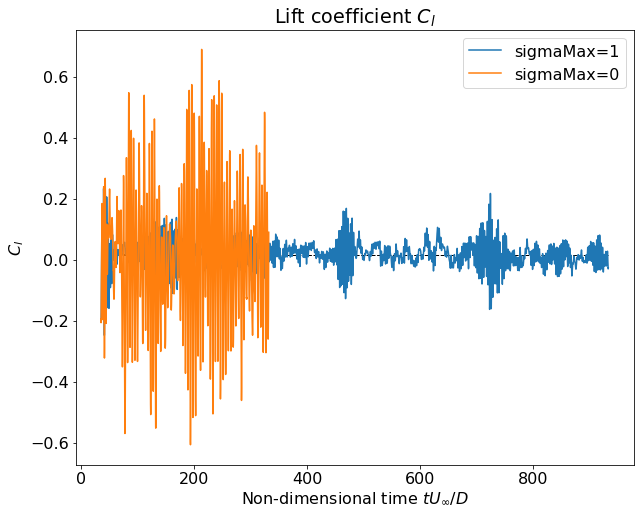

In [7]:
plt.figure(figsize=(10,8))

for run in alldata:
    label = run[0]
    t     = run[1]
    forcedat = run[2]
    avgt  = run[3]
    Cd = (forcedat[:,1]+forcedat[:,4])/(Q*A)
    Cl = (forcedat[:,2]+forcedat[:,5])/(Q*A)
    # Calculate averaged Cp, Cd
    avgCd = timeaverage(t, Cd, avgt[0], avgt[1])
    avgCl = timeaverage(t, Cl, avgt[0], avgt[1])
    plt.plot(t,Cl, label=label)
    plt.hlines(avgCl, np.min(t), np.max(t), linestyles='dashed', linewidth=1)
plt.xlabel(r'Non-dimensional time $t U_{\infty}/D$');
plt.ylabel('$C_l$')
plt.title('Lift coefficient $C_l$');
plt.legend()

## Plot Spectra

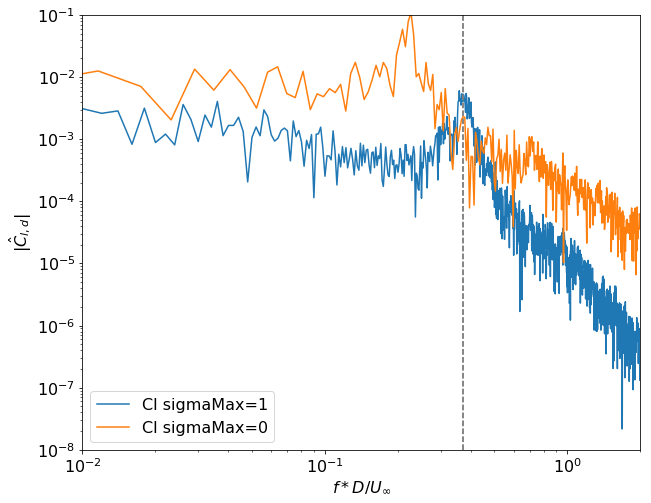

In [8]:
plt.figure(figsize=(10,8))

for run in alldata:
    label = run[0]
    t     = run[1]
    forcedat = run[2]
    avgt  = run[3]
    filt = ((t[:] >= avgt[0]) & (t[:] <= avgt[1]))
    tfiltered = t[filt]*D/U
    
    Cd = (forcedat[:,1]+forcedat[:,4])/(Q*A)
    Cl = (forcedat[:,2]+forcedat[:,5])/(Q*A)
    Cdfiltered = Cd[filt]
    Clfiltered = Cl[filt]
    
    f, Cdspectra = getFFT(tfiltered, Cdfiltered, normalize=True)
    f, Clspectra = getFFT(tfiltered, Clfiltered, normalize=True)
    
    plt.loglog(f*D/U, abs(Clspectra), label='Cl '+label)
    plt.axvline(0.37, linestyle='--', color='gray')
    
plt.xlim([1E-2,2]);    
plt.ylim([1E-8, 1E-1]);
plt.xlabel(r'$f*D/U_\infty$');
plt.ylabel(r'$|\hat{C}_{l,d}|$')
plt.legend()

## Plot Cd versus Reynolds number

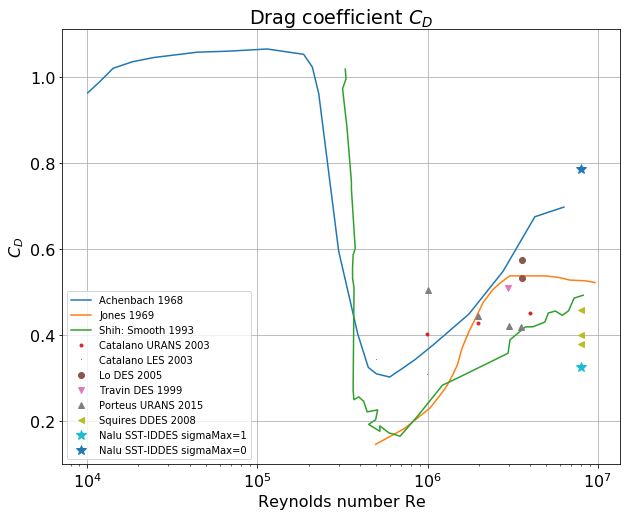

In [9]:
plt.figure(figsize=(10,8))
litCdData.plotEXP()
litCdData.plotCFD()

for run in alldata:
    label = run[0]
    t     = run[1]
    forcedat = run[2]
    avgt  = run[3]
    dict  = run[4]
    
    Cd = (forcedat[:,1]+forcedat[:,4])/(Q*A)
    Cl = (forcedat[:,2]+forcedat[:,5])/(Q*A)
    # Calculate averaged Cp, Cd
    avgCd = timeaverage(t, Cd, avgt[0], avgt[1])
    avgCl = timeaverage(t, Cl, avgt[0], avgt[1])
    
    vis   = dict['vis']
    ReNum = rho*U*D/vis
    plt.semilogx(ReNum, avgCd, '*',   ms=10, label='Nalu SST-IDDES '+label)
plt.grid()
plt.legend(fontsize=10)

plt.xlabel(r'Reynolds number Re');
plt.ylabel('$C_D$')
plt.title('Drag coefficient $C_D$');

In [10]:
# Write the YAML file these averaged quantities
import yaml
if saveinfo:
    savedict={'Re':float(ReNum), 'avgCd':float(avgCd), 'avgCl':float(avgCl)}
    f=open('istats.yaml','w')
    f.write('# Averaged quantities from %f to %f\n'%(avgt[0], avgt[1]))
    f.write('# Grid: grid0\n')
    f.write(yaml.dump(savedict, default_flow_style=False))
    f.close()